# Tp2 simulacion

# Ejercicio 1

### A partir del universo de página webs provistas junto al enunciado, se pide:

### ● Calcular el pagerank para cada sitio. (Mostrar la matriz generada)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
!pip install beautifulsoup4 simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import sympy

import networkx as nx
from networkx.drawing.nx_pydot import write_dot
from subprocess import check_call

import graphviz as gv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from bs4 import BeautifulSoup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
archivos = (
        'angelinajolie.html', 
        'bradpitt.html',
        'jenniferaniston.html', 
        'jonvoight.html',
        'martinscorcese.html', 
        'robertdeniro.html',
    ) #esta ordenada

sitios = ["http://" + x for x in archivos] #tambien ordenada por extension

In [ ]:
html = {}
for name in archivos:
    with open("/content/drive/MyDrive/Tp2/paginas/" + name) as f:
        bs = BeautifulSoup(f.read())
        html[f"http://{name}"] = bs

In [ ]:
matriz_probabilidades = []
for sitio in sitios: #se recorren en orden alfabetico
    frecuencias = {s : 0 for s in sitios}
    refs = html[sitio].find_all('a', href=True)

    # calculamos la frecuencia de cada href en la pagina
    for r in refs:
        # asumimos que no hay otros href en las paginas 
        # que no sean las listadas en `sitios`
        frecuencias[r['href']] += 1
    
    if not refs:
        # 1/len(sitios) o 1/(len(sitios) - 1) solo para los otros sitios?
        probabilidades = [1/len(sitios) for url in sitios]
    else:
        probabilidades = [0]*len(sitios)
        for r in refs:
            href = r['href']
            probabilidades[sitios.index(href)] = frecuencias[href]/len(refs)

    matriz_probabilidades.append(probabilidades)

In [ ]:
for f in matriz_probabilidades:
    print(f)

[0, 0.5, 0, 0.5, 0, 0]
[0.5, 0, 0.25, 0, 0.25, 0]
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
[0.6666666666666666, 0.3333333333333333, 0, 0, 0, 0]
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
[0, 0, 0, 0, 1.0, 0]


In [ ]:
# Armo la matriz de transiciones 
#Estado 0: Angelina jolie
#Estado 1: Brad Pitt
#Estado 2: Jennifer Aniston
#Estado 3: Jon Voight
#Estado 4: Martin Scorcese
#Estado 5: Robert De Niro

# P_matrix = [ [0  , 1/2, 0  , 1/2, 0  , 0  ],
#              [1/2, 0  , 1/4, 0  , 1/4, 0  ],
#              [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
#              [2/3, 1/3, 0  , 0  , 0  , 0  ],
#              [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
#              [0  , 0  , 0  , 0  , 1  , 0  ],
#     ]

P_matrix = matriz_probabilidades

P = np.array(P_matrix)

In [ ]:
_mp = sympy.Matrix(P).applyfunc(lambda x: sympy.Symbol(f'{x:.2f}'))
_mp

Matrix([
[0.000, 0.500, 0.000, 0.500, 0.000, 0.000],
[0.500, 0.000, 0.250, 0.000, 0.250, 0.000],
[0.167, 0.167, 0.167, 0.167, 0.167, 0.167],
[0.667, 0.333, 0.000, 0.000, 0.000, 0.000],
[0.167, 0.167, 0.167, 0.167, 0.167, 0.167],
[0.000, 0.000, 0.000, 0.000, 1.000, 0.000]])

Dibujamos la matriz

In [ ]:
g_ej1 = nx.MultiDiGraph()

for i in range(0,len(P_matrix)):    
    for j in range(0,len(P_matrix)):
        prob = P_matrix[i][j]
        if prob > 0:
            g_ej1.add_edge(i, j, weight=prob, label="{:.02f}".format(prob))

In [ ]:
%config InlineBackend.figure_format = 'png'

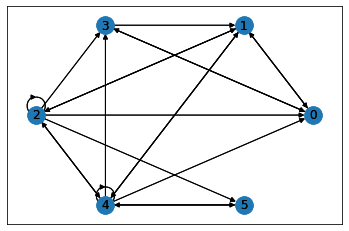

In [ ]:
ax = plt.subplot(111)

pos=nx.circular_layout(g_ej1)
nx.draw_networkx(g_ej1, pos, with_labels=True)
labels = nx.get_edge_attributes(g_ej1,'weight')

#por algun motivo la tupla del nodo tiene 3 componentes ¯\_(ツ)_/¯
labels = {key[:2] : round(v,2) for key, v in labels.items()}

#nx.draw_networkx_edge_labels(g_ej1, pos, edge_labels=labels)
nx.draw_networkx(g_ej1, pos)

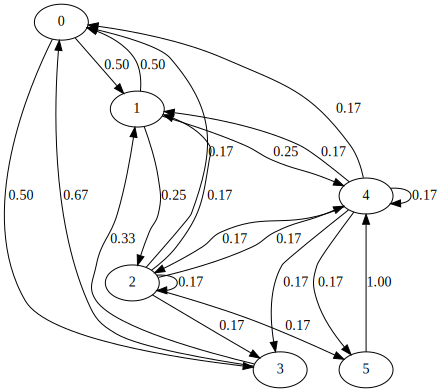

In [ ]:
write_dot(g_ej1, 'ej1.dot')

#nfile = 'ej1.png' 
#check_call(['dot', '-Tpng', 'ej1.dot', '-o', nfile])


#img = mpimg.imread(nfile)
#plt.axis('off')
#plt.imshow(img)
#plt.show()

gv.Source.from_file('ej1.dot', format='png')

Resuelvo el sistema estacionario para hallar el vector de probabilidad de estados asintoticos PI.

Siendo $P$ la matriz de transiciones de la cadena de Markov y $\pi = [\pi_1, \pi_2, \dots \pi_6]$ el vector de las probabilidades asintóticas, partimos de la condicion $\mathbf{\pi} P = P$ teniendo en cuenta que las componentes $\pi_{i}$ de $\pi$ cumplen $\sum_{i=1}^{6} \pi_i = 1$
$$\begin{align}
\pi P = \pi \\
\pi P - \pi = 0 \\
\pi (P - I) = 0
\end{align}$$
Incluyendo la condicion $\sum_{i=1}^{6} \pi_i = 1$ en la ecuacion equivale a agregar una columna de 1s a la matriz $P - I$ e igualar la ecuacion al vector de 0s con un 1 an la última posición. Llamamos a la nueva matriz "$Q$":
$$\begin{align}
\pi (P - I) = 0 \\
\pi Q = [0\ 0\ 0\ 0\ 0\ 0\ 1] = b \\
Q^T \pi^T = b^T \\
Q Q^T \pi^T = Q b^T
\end{align}$$
donde en los ultimos 2 pasos pasamos el sistema a la forma que espera el solver de numpy, teniendo en cuenta que el vector $Q b^T$ es simplemente un vector de 1s $\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}$ de longitud 6

In [ ]:
A = (P - np.eye(6))
ones = np.ones(A.shape[0])
A = np.c_[A,ones] # concatena la matriz A con el vector columna de 1s

aat = A @ A.T
b = ones
PI = np.linalg.solve(aat,b)
PI

array([0.28571429, 0.24489796, 0.10204082, 0.18367347, 0.14285714,
       0.04081633])

In [ ]:
# Verifico que el vector de probas de estados asintoticos sume 1 
print(sum(PI))

1.0


Si elevo P a un numero grande (100 por ejemplo) deberia llegar a lo mismo
(Ver el tema de los decimales)

In [ ]:
result = np.linalg.matrix_power(P, 100)
#print(result)
x = sympy.Matrix(result).applyfunc(lambda x: sympy.Symbol(f'{x:.3f}'))
x

Matrix([
[0.286, 0.245, 0.102, 0.184, 0.143, 0.041],
[0.286, 0.245, 0.102, 0.184, 0.143, 0.041],
[0.286, 0.245, 0.102, 0.184, 0.143, 0.041],
[0.286, 0.245, 0.102, 0.184, 0.143, 0.041],
[0.286, 0.245, 0.102, 0.184, 0.143, 0.041],
[0.286, 0.245, 0.102, 0.184, 0.143, 0.041]])

### ● Simular 20 búsquedas de palabras elegidas al azar dentro de las existentes en los textos de las páginas, y mostrar las mismas en función de la importancia asignada a cada sitio.

Elegimos 20 palabras de entre todos los textos: pronombres, cadenas léxicas del mundo del espectáculo o simplemente palabras comunes en textos biográficos  
En órden alfabético:  
* Academy
* Acting
* Action
* Actor
* Actress
* Award
* Born
* Bull
* Cinema
* Comedy
* Director
* Film
* He
* Hollywood
* Performance
* Picture
* Role
* Screen
* She
* Television

In [ ]:
palabras = [
    'Academy',
    'Acting',
    'Action',
    'Actor',
    'Actress',
    'Award',
    'Born',
    'Bull',
    'Cinema',
    'Comedy',
    'Director',
    'Film',
    'He',
    'Hollywood',
    'Performance',
    'Picture',
    'Role',
    'Screen',
    'She',
    'Television'
    ]

In [ ]:
import re

In [ ]:
patrones_busqueda = {word: re.compile(f"(?<!\w){word}(?!\w)", re.I) for word in palabras}

Buscamos la cantidad de incidencias de cada palabra en cada página:

In [ ]:
from collections import defaultdict
busquedas_por_palabra = defaultdict(list)

for palabra in palabras:
    for s in sitios:
        matches = patrones_busqueda[palabra].findall(html[s].text)
        busquedas_por_palabra[palabra].append((s, len(matches)))

In [ ]:
busq = busquedas_por_palabra
for palabra in busquedas_por_palabra:
    print(f"busquedas para la palabra: `{palabra}`".center(100, '~'))
    busq[palabra] = sorted(busq[palabra],
                           key=lambda x:PI[sitios.index(x[0])],
                           reverse=True)
    for sitio, coincidencias in busq[palabra]:
        if coincidencias == 0:
            continue
        s1 = f"sitio: {sitio} "
        s2 = f"| cantidad de coincidencias: {coincidencias} |        "
        s3 = f"ranking sitio (pr): {round(PI[sitios.index(sitio)],3)}"
        print(f"{s1 : <40}{s2 : ^10}{s3 : <50}")
    print("")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~busquedas para la palabra: `Academy`~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sitio: http://angelinajolie.html        | cantidad de coincidencias: 2 |        ranking sitio (pr): 0.286                         
sitio: http://bradpitt.html             | cantidad de coincidencias: 4 |        ranking sitio (pr): 0.245                         
sitio: http://jonvoight.html            | cantidad de coincidencias: 2 |        ranking sitio (pr): 0.184                         
sitio: http://martinscorcese.html       | cantidad de coincidencias: 1 |        ranking sitio (pr): 0.143                         
sitio: http://robertdeniro.html         | cantidad de coincidencias: 2 |        ranking sitio (pr): 0.041                         

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~busquedas para la palabra: `Acting`~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sitio: http://angelinajolie.html        | cantidad de coincidencias: 1 |        ranking sitio (pr): 0.286                         
sitio: http

# Ejercicio 2

En base a lo presentado en el trabajo “Queuing theory application in imaging service analysis for small Earth observation satellites”, simular los resultados obtenidos sobre la longitud de imágenes en cola esperando ser
procesadas en la sección 3.1. Pure image capture service system 
El ejercicio se puede resolver utilizando simpy o programación tradicional (a elección del grupo)

In [ ]:
import simpy as sp

In [ ]:
class Satelite:
    def __init__(self, env: sp.Environment, tasa_de_procesamiento: float, tasa_de_descarga: float, capacidad_memoria: int) -> None:
      self.tasa_de_procesamiento = tasa_de_procesamiento
      self.tasa_de_descarga = tasa_de_descarga

      self.env = env

      self.cola = sp.Resource(env, capacity=capacidad_memoria)
      self.canal_de_descarga = sp.Resource(env)
      self.canal_de_procesamiento = sp.Resource(env)

      self.longitudes_de_cola = []
      self.tiempo_entre_arribos = []
      self.longitudes_de_cola_de_descarga = []


    def descargar_imagen(self, contador):
      tiempo = np.random.exponential(1/self.tasa_de_descarga)
      yield self.env.timeout(tiempo)
      
      #print(f"La imagen {contador} ya fue descargada en tiempo {self.env.now}")
      #print(f"La cola tiene {len(self.cola.queue) + len(self.canal_de_procesamiento.queue)} imágenes")
      #print(f"Hay {self.canal_de_procesamiento.count} imágenes siendo procesadas")
      #print(f"La cola de descargas tiene {len(self.canal_de_descarga.queue)} imágenes")
      #print(f"Hay {self.canal_de_descarga.count} imágenes siendo descargadas\n")


    def procesar_imagen(self, contador):
      tiempo = np.random.exponential(1/self.tasa_de_procesamiento)
      yield self.env.timeout(tiempo)

      #print(f"La imagen {contador} ya fue procesada en tiempo {self.env.now}")
      #print(f"La cola tiene {len(self.cola.queue) + len(self.canal_de_procesamiento.queue)} imágenes")
      #print(f"Hay {self.canal_de_procesamiento.count} imágenes siendo procesadas")
      #print(f"La cola de descargas tiene {len(self.canal_de_descarga.queue)} imágenes")
      #print(f"Hay {self.canal_de_descarga.count} imágenes siendo descargadas\n")


    def atender_solicitud(self, contador):
      #print(f"La imagen {contador} llega al sistema tiempo {self.env.now}\n")

      request_cola = self.cola.request()
      yield request_cola # solo podemos procesar la solicitud (tomar la imagen)
                         # si hay al menos un lugar disponible en la memoria del
                         # satelite (la cola de imagenes self.cola)

      with self.canal_de_procesamiento.request() as request:
        yield request

        #print(f"La imagen {contador} pasa a ser procesada en tiempo {self.env.now}")
        #print(f"La cola tiene {len(self.cola.queue) + len(self.canal_de_procesamiento.queue)} imágenes")
        #print(f"Hay {self.canal_de_procesamiento.count} imágenes siendo procesadas")
        #print(f"La cola de descargas tiene {len(self.canal_de_descarga.queue)} imágenes")
        #print(f"Hay {self.canal_de_descarga.count} imágenes siendo descargadas\n")
        yield self.env.process(self.procesar_imagen(contador))

      with self.canal_de_descarga.request() as request:
        yield request
        self.cola.release(request_cola) # solo cuando comenzamos a descargar la imagen
                                        # la quitamos de la memoria

        #print(f"La imagen {contador} pasa a ser descargada en tiempo {self.env.now}")
        #print(f"La cola tiene {len(self.cola.queue) + len(self.canal_de_procesamiento.queue)} imágenes")
        #print(f"Hay {self.canal_de_procesamiento.count} imágenes siendo procesadas")
        #print(f"La cola de descargas tiene {len(self.canal_de_descarga.queue)} imágenes")
        #print(f"Hay {self.canal_de_descarga.count} imágenes siendo descargadas\n")
        yield self.env.process(self.descargar_imagen(contador))

      yield self.env.timeout(0)
      

In [ ]:
def simular(env: sp.Environment, satelite: Satelite, cantidad: int, tasa_arribos: float):
    #if cantidad < 0 or type(cantidad) != int:
    #    raise ValueError(f"'cantidad' no puede ser menor a 0 ni no entero")

    for i in range(cantidad):
        tiempo = np.random.exponential(1/tasa_arribos)
        yield env.timeout(tiempo)
        env.process(satelite.atender_solicitud(i))

        satelite.longitudes_de_cola.append(len(satelite.cola.queue))
        satelite.tiempo_entre_arribos.append(tiempo)
        satelite.longitudes_de_cola_de_descarga.append(len(satelite.canal_de_descarga.queue))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
def generar_simulacion(tasa_de_arribos, tasa_de_procesamiento, tasa_de_descarga, capacidad_memoria, cantidad_de_solicitudes):
    env = sp.Environment()
    satelite = Satelite(env, tasa_de_procesamiento=tasa_de_procesamiento, tasa_de_descarga=tasa_de_descarga, capacidad_memoria=capacidad_memoria)

    env.process(simular(env, satelite, cantidad_de_solicitudes, tasa_de_arribos))

    env.run()

    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
    )
    fig.set_figheight(15)
    fig.set_figwidth(10)

    ax1.set_title('Longitud de la cola de procesamiento')
    sns.kdeplot(satelite.longitudes_de_cola, ax=ax1)
    ax1.set_xlabel('Cantidad de imágenes')
    ax1.set_ylabel('Densidad')
    ax1.set_xlim(0, None)


    ax2.set_title('Longitud de la cola de descarga')
    sns.kdeplot(satelite.longitudes_de_cola_de_descarga, ax=ax2)
    ax2.set_xlabel('Cantidad de imágenes')
    ax2.set_ylabel('Densidad')
    ax2.set_xlim(0, None)

    plt.show()

In [ ]:
from IPython.display import display
from ipywidgets import FloatSlider, IntSlider, interactive

In [ ]:
tasa_de_arribos_slider = FloatSlider(value=5, min=0.5, max=10, step=0.5, description="tasa de arribos")
tasa_de_procesamiento_slider = FloatSlider(value=5, min=0.5, max=10, step=0.5, description="tasa de procesamiento")
tasa_de_descarga_slider = FloatSlider(value=5, min=0.5, max=10, step=0.5, description="tasa de descarga")
capacidad_de_memoria_slider = IntSlider(value=20, min=1, max=50, step=1, description="capacidad de memoria")
cantidad_de_solicitudes_slider = IntSlider(value=10000, min=10000, max=100000, step=10000, description="cantidad de solicitudes")

In [ ]:
inter = interactive(generar_simulacion, {'manual': True}, tasa_de_arribos=tasa_de_arribos_slider, tasa_de_procesamiento=tasa_de_procesamiento_slider, tasa_de_descarga=tasa_de_descarga_slider, capacidad_memoria=capacidad_de_memoria_slider, cantidad_de_solicitudes=cantidad_de_solicitudes_slider)
display(inter)

interactive(children=(FloatSlider(value=3.0, description='tasa de arribos', max=10.0, min=0.5, step=0.5), Floa…

# Ejercicio 3

Se está diseñando un web service, el cual cada vez que es invocado consulta a una base de datos.

Se estima que el tiempo que transcurre entre cada llamada al servicio se puede modelar según una distribución
exponencial con media lambda = 4 segundos

Se debe decidir la arquitectura de base de datos a utilizar entre las dos siguientes:

**1) Utilizar 2 bases de datos distribuidas.**

  Con probabilidad p = 0.7las solicitudes son atendidas por la base 1 y con probabilidad q = 1-p son atendidos por la base de datos 2.
El tiempo que demora cada base de datos en atender una solicitud sigue una distribución exponencial con medias 0.7 segundos y 1 segundo, y respectivamente.

**2) Utilizar 1 base de datos central.**

En este caso la demora en resolver una solicitud sigue una distribución exponencial con media 0.8 segundos


Simular para cada opción 100.000 solicitudes procesadas, determinando:

● El tiempo medio de espera entre que la solicitud llega y puede ser procesada (suponer que ninguna conexión cae por timeout).

● La fracción de las solicitudes que no esperaron para ser procesadas.

● Probar con distintos escenarios, modificando los parámetros del ejercicio.

In [ ]:
SOLICITUDES = 100000
TASA_ARRIBOS = 4
TASA_ALT_DOS_PROC = 1/0.8 #Media

PROB_B_UNO = 0.7
PROB_B_DOS = 1 - PROB_B_UNO

TASA_ALT_UNO_PROC_UNO = 0.7 #Media
TASA_ALT_UNO_PROC_DOS = 1 #Media

In [ ]:
def tiempo_salida(llegadas, procesamiento):
  if len(llegadas) == 0:
    return []
  salidas = [procesamiento[0]+llegadas[0]]
  largo = len(llegadas)

  for i in range(1, largo):
    inicio = llegadas[i]
    if salidas[i-1] > inicio:
      inicio = salidas[i-1]
    salidas.append(inicio+procesamiento[i])

  return salidas

In [ ]:
def tiempo_espera(llegadas, salidas):
  if len(llegadas) == 0:
    return []
  esperas = [0]
  largo = len(llegadas)

  for i in range(1, largo):
    inicio = salidas[i-1] - llegadas[i]
    if inicio < 0:
      inicio = 0
    esperas.append(inicio)

  return esperas

In [ ]:
def simular_2(cantidad, tasa_arribo, print_data = True, tasa_proc = TASA_ALT_DOS_PROC):
  llegadas = np.random.exponential(tasa_arribo, cantidad)
  llegadas = np.cumsum(llegadas)
  procesamientos = np.random.exponential(tasa_proc, cantidad)
  salidas = np.array(tiempo_salida(llegadas, procesamientos))
  esperas = np.array(tiempo_espera(llegadas, salidas))
  n_zeros = esperas[np.where(esperas==0)].size
  if print_data:
    print(f"Tiempos De Llegadas - {np.around(llegadas,2)}")
    print(f"Tiempos De Procesamientos - {np.around(procesamientos,2)}")
    print(f"Tiempos De Salidas - {np.around(salidas,2)}")
    print(f"Tiempos De Esperas - {np.around(esperas,2)}")
    print(f"Tiempo Medio De Espera - {np.mean(esperas)}")
    print(f"Fraccion De Eventos Sin Espera - {n_zeros/len(esperas)}")
  return np.mean(esperas),n_zeros/len(esperas), esperas

In [ ]:
def simular_1(cantidad, tasa_arribo, print_data = True, tasa_1 = TASA_ALT_UNO_PROC_UNO, tasa_2 = TASA_ALT_UNO_PROC_DOS, proba_uno = PROB_B_UNO):
  llegadas = np.random.exponential(tasa_arribo, cantidad)
  prob_bases = np.random.uniform(0,1,cantidad)
  llegadas_1 = []
  llegadas_2 = []
  for i, prob in enumerate(prob_bases):
    if prob < proba_uno:
      llegadas_1.append(llegadas[i])
    else:
      llegadas_2.append(llegadas[i])
  llegadas_1 = np.cumsum(llegadas_1)
  llegadas_2 = np.cumsum(llegadas_2)

  procesamientos_1 = np.random.exponential(tasa_1, len(llegadas_1))
  procesamientos_2 = np.random.exponential(tasa_2, len(llegadas_2))
  
  salidas_1 = np.array(tiempo_salida(llegadas_1, procesamientos_1))
  salidas_2 = np.array(tiempo_salida(llegadas_2, procesamientos_2))

  esperas_1 = np.array(tiempo_espera(llegadas_1, salidas_1))
  esperas_2 = np.array(tiempo_espera(llegadas_2, salidas_2))
  
  esperas = []
  n_1 = 0
  n_2 = 0
  for i, prob in enumerate(prob_bases):
    if prob < proba_uno:
      esperas.append(esperas_1[n_1])
      n_1 += 1
    else:
      esperas.append(esperas_2[n_2])
      n_2 += 1
  esperas = np.array(esperas)
  n_zeros = esperas[np.where(esperas==0)].size

  if print_data:
    print("BASE 1")
    print(f"Tiempos De Llegadas - {np.around(llegadas_1,2)}")
    print(f"Tiempos De Procesamientos - {np.around(procesamientos_1,2)}")
    print(f"Tiempos De Salidas - {np.around(salidas_1,2)}")
    print(f"Tiempos De Esperas - {np.around(esperas_1,2)}")
    print("=="*10)
    print("BASE 2")
    print(f"Tiempos De Llegadas - {np.around(llegadas_2,2)}")
    print(f"Tiempos De Procesamientos - {np.around(procesamientos_2,2)}")
    print(f"Tiempos De Salidas - {np.around(salidas_2,2)}")
    print(f"Tiempos De Esperas - {np.around(esperas_2,2)}")
    print("Medias")
    print(np.around(esperas,2))
    print(f"Tiempo Medio De Espera - {np.mean(esperas)}")
    print(f"Fraccion De Eventos Sin Espera - {n_zeros/len(esperas)}")
  
  return np.mean(esperas),n_zeros/len(esperas), esperas

100 test de 100000 solicitudes

In [ ]:
amount_tests = 100

means_1 = []
fracs_1 = []

means_2 = []
fracs_2 = []

for i in range(amount_tests):
  mean_1, frac_1, _x = simular_1(SOLICITUDES, TASA_ARRIBOS, False)
  means_1.append(mean_1)
  fracs_1.append(frac_1)
  mean_2, frac_2, _x = simular_2(SOLICITUDES, TASA_ARRIBOS, False)
  means_2.append(mean_2)
  fracs_2.append(frac_2)

means_1 = np.array(means_1)
fracs_1 = np.array(fracs_1)

means_2 = np.array(means_2)
fracs_2 = np.array(fracs_2)

print(f"Se realizaron {amount_tests} simulaciones de {SOLICITUDES} solicitudes")
print("Sistema 1")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_1)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_1)}")
print("Sistema 2")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_2)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_2)}")

Se realizaron 100 simulaciones de 100000 solicitudes
Sistema 1
Media Tiempo Medio De Esperas - 0.20281081852656396
Media Fraccion De Eventos Sin Espera - 0.80231
Sistema 2
Media Tiempo Medio De Esperas - 0.5690144788494762
Media Fraccion De Eventos Sin Espera - 0.6865


Vemos que en el sistema 1 hay una mejor fracción de eventos sin espera y también un mejor tiempo medio de espera. En ambos casos con una gran diferencia ya que el tiempo es casi la mitad y la fraccion es el doble.

Por eso se puede concluir que el sistema 1 es mas eficiente.

Entendemos que esto pasa porque al separarse en 2 al generarse una demora en el sistema 1 demora a todos los procesos siguientes, mientras que en el sistema 1 a pesar de ser mas lentos los procesamientos una demora en uno solo demora a una fraccion de la totalidad de las solicitudes.

Text(0, 0.5, 'Tiempo En Segundos')

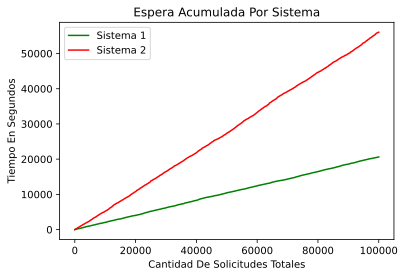

In [ ]:
_mean_1, _frac_1, esperas_1 = simular_1(SOLICITUDES, TASA_ARRIBOS, False)
_mean_2, _frac_2, esperas_2 = simular_2(SOLICITUDES, TASA_ARRIBOS, False)

espera_acum_1 = np.cumsum(esperas_1)
espera_acum_2 = np.cumsum(esperas_2)

plt.plot(range(SOLICITUDES), espera_acum_1, color = "g", label = "Sistema 1")
plt.plot(range(SOLICITUDES), espera_acum_2, color = "r", label = "Sistema 2")
plt.legend()
plt.title("Espera Acumulada Por Sistema")
plt.xlabel("Cantidad De Solicitudes Totales")
plt.ylabel("Tiempo En Segundos")

## Probamos con otros valores

### Modificando Tasa de arribos

Probamos aumentar y disminuir la media de arribos para ver como se comportan ambos sitemas.

Al disminuir la media de tiempo entre arribos esperamos que en ambos sistemas el tiempo medio de espera aumente y la media de la fraccion de eventos sin espera se aleje de 1.

Al aumentar la media de tiempo entre arribos esperamos que en ambos sistemas el tiempo medio de espera disminuya y la media de la fraccion de eventos sin espera se acerque mas a 1.



In [ ]:
NUEVA_TASA = 1
mean_1, frac_1, _x = simular_1(SOLICITUDES, NUEVA_TASA, False)
mean_2, frac_2, _x = simular_2(SOLICITUDES, NUEVA_TASA, False)
print(f"Se realizaron 1 test de {SOLICITUDES} solicitudes")
print("Sistema 1")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_1)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_1)}")
print("Sistema 2")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_2)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_2)}")

Se realizaron 1 test de 100000 solicitudes
Sistema 1
Media Tiempo Medio De Esperas - 30.84726940338986
Media Fraccion De Eventos Sin Espera - 0.20801
Sistema 2
Media Tiempo Medio De Esperas - 12038.282810803063
Media Fraccion De Eventos Sin Espera - 3e-05


In [ ]:
NUEVA_TASA = 8
mean_1, frac_1, _x = simular_1(SOLICITUDES, NUEVA_TASA, False)
mean_2, frac_2, _x = simular_2(SOLICITUDES, NUEVA_TASA, False)
print(f"Se realizaron 1 test de {SOLICITUDES} solicitudes")
print("Sistema 1")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_1)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_1)}")
print("Sistema 2")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_2)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_2)}")

Se realizaron 1 test de 100000 solicitudes
Sistema 1
Media Tiempo Medio De Esperas - 0.08619043978404403
Media Fraccion De Eventos Sin Espera - 0.9021
Sistema 2
Media Tiempo Medio De Esperas - 0.22946910556466174
Media Fraccion De Eventos Sin Espera - 0.84587


### Modificando tasas de procesamiento

Al disminuir la media de procesamiento esperamos que los tiempos de espera disminuyan y la fraccion de eventos sin espera tienda a uno.

El aumentarla esperamos lo contrario.

In [ ]:
NUEVA_TASA = 0.1
mean_1, frac_1, _x = simular_1(SOLICITUDES, TASA_ARRIBOS, False, NUEVA_TASA, NUEVA_TASA)
mean_2, frac_2, _x = simular_2(SOLICITUDES, TASA_ARRIBOS, False, NUEVA_TASA)
print(f"Se realizaron 1 test de {SOLICITUDES} solicitudes")
print("Sistema 1")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_1)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_1)}")
print("Sistema 2")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_2)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_2)}")

Se realizaron 1 test de 100000 solicitudes
Sistema 1
Media Tiempo Medio De Esperas - 0.0025386454799458907
Media Fraccion De Eventos Sin Espera - 0.97519
Sistema 2
Media Tiempo Medio De Esperas - 0.002583010929657546
Media Fraccion De Eventos Sin Espera - 0.97476


In [ ]:
NUEVA_TASA = 100
mean_1, frac_1, _x = simular_1(SOLICITUDES, TASA_ARRIBOS, False, NUEVA_TASA, NUEVA_TASA)
mean_2, frac_2, _x = simular_2(SOLICITUDES, TASA_ARRIBOS, False, NUEVA_TASA)
print(f"Se realizaron 1 test de {SOLICITUDES} solicitudes")
print("Sistema 1")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_1)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_1)}")
print("Sistema 2")
print(f"Media Tiempo Medio De Esperas - {np.mean(mean_2)}")
print(f"Media Fraccion De Eventos Sin Espera - {np.mean(frac_2)}")

Se realizaron 1 test de 100000 solicitudes
Sistema 1
Media Tiempo Medio De Esperas - 2778428.025780333
Media Fraccion De Eventos Sin Espera - 3e-05
Sistema 2
Media Tiempo Medio De Esperas - 4789769.188265715
Media Fraccion De Eventos Sin Espera - 1e-05


# Ejercicio 4

Una entidad financiera está analizando cambiar uno de sus cajeros automáticos por uno con la funcionalidad de
reciclador de billetes (si un cliente realiza un depósito de efectivo, ese efectivo estará disponible para que lo
pueda retirar otro cliente).
El cajero automático actual, que se quiere reemplazar, es de tipo estándar. No recicla los billetes, sino que
posee dos compartimentos, uno con dinero para entregar y otro donde guarda el dinero que se deposita.
Esto presenta los siguientes problemas:

● Si no tiene más efectivo para entregar en el compartimento de retiro de dinero, no entrega efectivo aunque tenga en el compartimento de depósitos.

● Si el compartimento que recibe los depósitos se completa, no puede recibir más.
La entidad conoce que con el cajero actual el 20% de los clientes se retiraba sin poder extraer dinero, y sóloacepta cambiarlo si este porcentaje disminuye.

Por simplicidad suponer que el cajero sólo expende billetes de $100, tiene una capacidad máxima de 2000 billetes, y comienza el día con su carga completa.

Si un cliente quiere extraer dinero y el cajero no cuenta con la suma suficiente, se va del mismo sin retirar nada.

Algo similar ocurre cuando un cliente desea depositar efectivo y la capacidad máxima de billetes en el cajero fue alcanzada, retirándose sin poder depositar.

En el relevamiento que realizó la entidad diferenció a sus clientes en dos grupos:

Grupo 1:
Sólo retiran efectivo, y corresponden al 75% de los clientes que arriban.
El tiempo que utilizan el cajero se puede modelar con una distribución exponencial de media 90 segundos.
Cada cliente de este grupo, extrae una cantidad de billetes que sigue una distribución uniforme [3,50].

Grupo 2:
Sólo realizan depósitos, son el 25% de los clientes totales.
Utilizando el cajero un tiempo que siguen una distribución exponencial de media 5 minutos.
Cada cliente de este grupo, deposita una cantidad de billetes que se puede modelar utilizando una distribución uniforme [10,110].

La frecuencia de arribos de clientes es de 1 cliente cada 10 minutos con distribución exponencial.

Se pide:

a. Simular 1000 días completos de 24 hrs.

b. Para un día en particular graficar la cantidad de billetes en el cajero luego de cada transacción.

c. Calcular el tiempo medio que los clientes demoraron en el sistema (espera + utilización del cajero)

d. ¿Recomienda a la entidad que implemente el cambio de cajero?
El ejercicio se puede resolver utilizando Simpy o programación tradicional (a elección del grupo)

In [ ]:
from random import randint

In [ ]:
CAPACIDAD = 2000

PROB_RETIRO = 0.75
PROB_DEP = 1 - PROB_RETIRO

DEMORA_RETIRO = 90
MIN_RETIRO = 3
MAX_RETIRO = 50

DEMORA_DEPOSITO = 300
MIN_DEPOSITO = 10
MAX_DEPOSITO = 110

TASA_ARRIBOS = 600

SEGUNDOS_DIA = 24*60*60

In [ ]:
def simular_banco(tasa_arribo, cantidad_billetes = CAPACIDAD, print_data = True):
  llegadas = []
  suma = sum(llegadas) # = 0
  while suma < SEGUNDOS_DIA:
    aux = np.random.exponential(tasa_arribo, 1)
    llegadas.append(aux[0])
    suma += aux[0]
  llegadas = np.cumsum(llegadas)

  prob_retiro = np.random.uniform(0,1, len(llegadas))

  billetes = cantidad_billetes
  interactuaron = 0
  no_interactuaron = 0

  billetes_t = [billetes]
  demoras = []

  for i, prob in enumerate(prob_retiro):
     if prob < PROB_RETIRO:
       demora = np.random.exponential(DEMORA_RETIRO,1)
       demoras.append(demora[0])

       retiro = randint(MIN_RETIRO, MAX_RETIRO)
       if retiro <= billetes:
         billetes -= retiro
         interactuaron += 1
       else:
         no_interactuaron += 1
     else:
       demora = np.random.exponential(DEMORA_DEPOSITO,1)
       demoras.append(demora[0])

       deposito = randint(MIN_DEPOSITO, MAX_DEPOSITO)
       if deposito + billetes <= CAPACIDAD:
         billetes += deposito
     billetes_t.append(billetes)

  salidas = tiempo_salida(llegadas, demoras)
  esperas = tiempo_espera(llegadas, salidas)
  ocupacion = salidas - llegadas

  esperas = np.array(esperas)
  n_zeros = esperas[np.where(esperas==0)].size

  if print_data:
    print(f"No esperaron {n_zeros} Transacciones")
    print(f"Esperaron {len(esperas)-n_zeros} Transacciones")
  

  return interactuaron, no_interactuaron, billetes_t, ocupacion

Una sola ejecucion

No esperaron 107 Transacciones
Esperaron 25 Transacciones


(0.0, 2100.0)

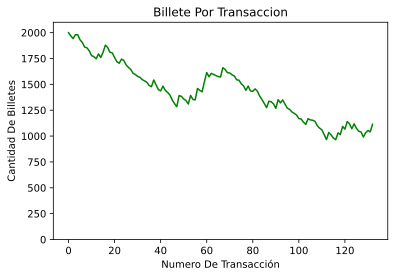

In [ ]:
inte, n_inte, billetes, ocupacion = simular_banco(TASA_ARRIBOS,CAPACIDAD, True)

plt.plot(range(len(billetes)), billetes, color = "g")
plt.title("Billete Por Transaccion")
plt.ylabel("Cantidad De Billetes")
plt.xlabel("Numero De Transacción")
plt.ylim(0, CAPACIDAD*1.05)

1000 ejecuciones y en cada dia se comienza con la capacidad maxima de billetes

In [ ]:
def reseteando(amount_tests, print_grafico = False):
  ocupacion = []
  fraccion_retiro = []
  billetes_tot = []

  for i in range(amount_tests):
    retiro, n_retiro, billetes, ocupacion_dia = simular_banco(TASA_ARRIBOS, CAPACIDAD, False)
    ocupacion.append(np.mean(ocupacion_dia))
    fraccion_retiro.append(retiro/(retiro+n_retiro))

    for billete in billetes:
      billetes_tot.append(billete)

  ocupacion = np.array(ocupacion)
  fraccion_retiro = np.array(fraccion_retiro)

  print(f"Se realizaron {amount_tests} simulaciones")
  print(f"Media Tiempo De Ocupación - {np.mean(ocupacion)}")
  print(f"Media Fraccion De Retiros Correctos - {np.mean(fraccion_retiro)}")

  if print_grafico:
    plt.plot(range(len(billetes_tot)), billetes_tot, color = "g")
    plt.title("Billete Por Transaccion")
    plt.ylabel("Cantidad De Billetes")
    plt.xlabel("Numero De Transacción")
    plt.ylim(0, CAPACIDAD*1.05)

In [ ]:
reseteando(1000, False)

Se realizaron 1000 simulaciones
Media Tiempo De Ocupación - 205.56570767947449
Media Fraccion De Retiros Correctos - 0.9995256541787305


Se realizaron 10 simulaciones
Media Tiempo De Ocupación - 186.76898578525967
Media Fraccion De Retiros Correctos - 1.0


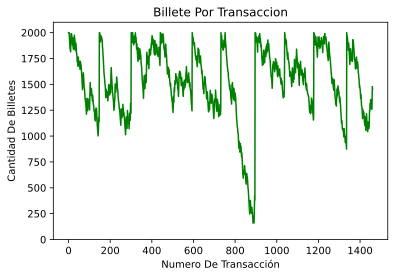

In [ ]:
reseteando(10, True)

1000 ejecuciones y en cada dia se comienza con la capacidad que queda del dia anterior

In [ ]:
def sin_resetear(amount_tests, print_grafico = False):

  ocupacion = []
  fraccion_retiro = []
  billetes_tot = []

  for i in range(amount_tests):
    if i == 0:
      retiro, n_retiro, billetes, ocupacion_dia = simular_banco(TASA_ARRIBOS, CAPACIDAD, False)
    else: 
      retiro, n_retiro, billetes, ocupacion_dia = simular_banco(TASA_ARRIBOS, billetes[-1], False)

    ocupacion.append(np.mean(ocupacion_dia))
    fraccion_retiro.append(retiro/(retiro+n_retiro))

    for billete in billetes:
      billetes_tot.append(billete)


  ocupacion = np.array(ocupacion)
  fraccion_retiro = np.array(fraccion_retiro)

  print(f"Se realizaron {amount_tests} simulaciones")
  print(f"Media Tiempo De Ocupación - {np.mean(ocupacion)}")
  print(f"Media Fraccion De Retiros Correctos - {np.mean(fraccion_retiro)}")

  if print_grafico:
    plt.plot(range(len(billetes_tot)), billetes_tot, color = "g")
    plt.title("Billete Por Transaccion")
    plt.ylabel("Cantidad De Billetes")
    plt.xlabel("Numero De Transacción")
    plt.ylim(0, CAPACIDAD*1.05)


In [ ]:
sin_resetear(1000, False)

Se realizaron 1000 simulaciones
Media Tiempo De Ocupación - 203.99153109173596
Media Fraccion De Retiros Correctos - 0.7895162922828504


Se realizaron 10 simulaciones
Media Tiempo De Ocupación - 222.1318286592162
Media Fraccion De Retiros Correctos - 0.8192119023645201


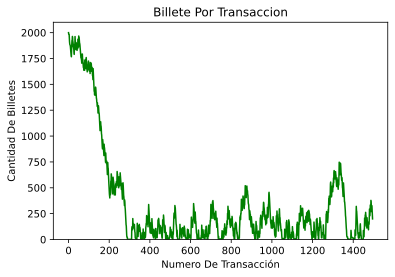

In [ ]:
sin_resetear(10, True)

En base a las simulaciones observamos que si al comienzo de cada dia reponemos la cantidad maxima de billetes en el cajero, menos del %1 de los clientes no podrian retirar dinero por lo cual el cambio seria conveniente.
De lo contrario, si los billetes no se reponen y solo se espera a que otros clientes depositen, solo el %79 de quienes quieren hacer retiros lo podran hacer de forma exitosa, por lo cual no recomendariamos hacer el cambio.